In [1]:
from diffusers.pipelines import StableDiffusionPipeline
import torch
from torchvision import transforms
from PIL import Image
import numpy as np
from diffusers import DDIMInverseScheduler, DDIMScheduler
import torch.nn.functional as F

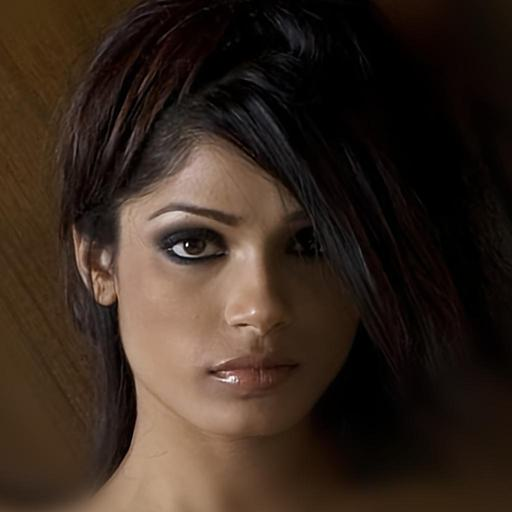

In [2]:
image_path = "../data/mmcelebahq/face/27000.jpg"
image = Image.open(image_path).convert("RGB")
image

In [3]:
device = "cuda:5"

In [4]:
t = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5],[0.5])
])
image_pt = t(image).unsqueeze(0).to(device)
image_pt.shape,image_pt.max(),image_pt.min()

(torch.Size([1, 3, 512, 512]),
 tensor(1., device='cuda:5'),
 tensor(-1., device='cuda:5'))

In [5]:
pipe:StableDiffusionPipeline = StableDiffusionPipeline.from_pretrained("../checkpoints/stablev15").to(device)
pipe.safety_checker = None
pipe.requires_safety_checker = False

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [6]:
pipe.scheduler = DDIMInverseScheduler.from_pretrained("../checkpoints/stablev15",subfolder="scheduler")

In [7]:
num_steps = 50

In [8]:
latents = pipe.vae.encode(image_pt,return_dict=True).latent_dist.sample()
latents = latents * pipe.vae.config.scaling_factor

In [9]:
latents.shape

torch.Size([1, 4, 64, 64])

In [10]:
inv_latents = pipe(prompt="She is wearing lipstick. She is attractive and has straight hair.", negative_prompt="", guidance_scale=1.,
                          width=512, height=512,
                          output_type='latent', return_dict=False,
                          num_inference_steps=num_steps, latents=latents)[0]


  0%|          | 0/50 [00:00<?, ?it/s]

In [11]:
inv_latents.shape

torch.Size([1, 4, 64, 64])

In [12]:
pipe.scheduler = DDIMScheduler.from_pretrained("../checkpoints/stablev15",subfolder="scheduler")

In [13]:
image = pipe(prompt="She is wearing lipstick. She is attractive and has straight and red hair.", negative_prompt="", guidance_scale=1.,
                          width=512, height=512, return_dict=False,
                          num_inference_steps=num_steps, latents=inv_latents)[0]

  0%|          | 0/50 [00:00<?, ?it/s]

In [14]:
type(image)

list

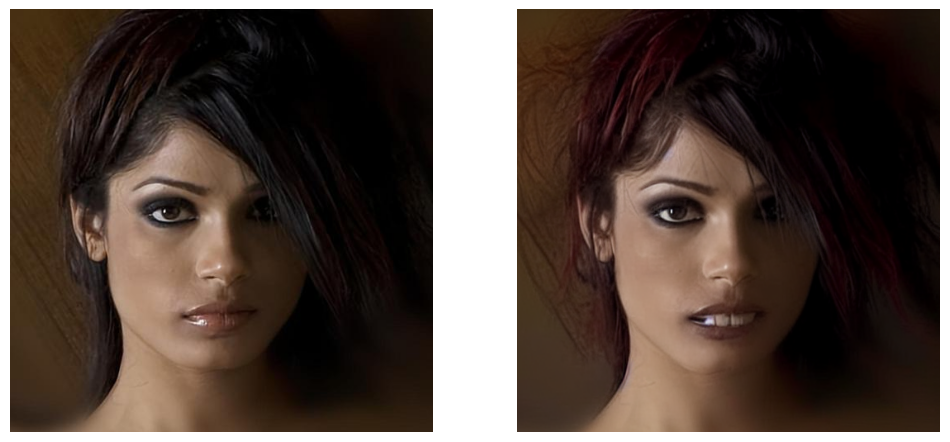

In [15]:
from matplotlib import pyplot as plt

image_raw = Image.open(image_path)

plt.figure(figsize=(12,8))

plt.subplot(1,2,1)
plt.imshow(image_raw)
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(image[0])
plt.axis("off")
plt.show()

In [16]:
image[0].size

(512, 512)